In [1]:
import math
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
#import tensorflow as tf
#from tensorflow.keras import layers
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,BatchNormalization
from keras.models import Model
from keras import Sequential
from keras import backend as K
from sklearn.cluster import KMeans,AffinityPropagation
import random
%matplotlib inline  


Using TensorFlow backend.
/home/chris-s/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chris-s/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chris-s/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chris-s/anaconda3/lib/python3.7/site-packages/t

In [2]:
%run on3_helpers.py

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
alpha = ['a','b','c','d','e','f','g', \
        'h','i','j','k','l','m','n','o','p','q','r', \
        's','t','u','v','w','x','y','z']

In [5]:
dbl = [x[0]+x[1] for x in itertools.product(alpha,alpha)]
trpl = [x[0]+x[1]+x[2] for x in itertools.product(alpha,alpha,alpha)]

In [6]:
ln = len(alpha)
ky = {}
lln2 = len(dbl)
ky2 = {}
ll3 = len(trpl)
ky3 = {}

for i in alpha:
    ky[i] = 1.0
    
for i in dbl:
    ky2[i] = 1.0
    
for i in trpl:
    ky3[i] = 1.0

In [7]:
def choose_random_words():
    wrds = []
    with open("words_alpha.txt") as f:
        for line in f:
            if random.random() < 0.015:
                wrds.append(line)
                
    return wrds

In [8]:
random_words = choose_random_words()

In [9]:
brk = 0
with open("words_alpha.txt") as f:
    for line in f:
        line = line.strip()
        
        for c in line:
            ky[c] = ky[c] + 1
            
        if len(line) > 2:
            for i in range(len(line)-1):
                pr = line[i:i+2]
                ky2[pr] = ky2[pr] + 1
        brk = brk + 1
        
        if len(line) > 3:
            for i in range(len(line)-2):
                pr = line[i:i+3]
                #print(pr)
                ky3[pr] = ky3[pr] + 1
                
        #if brk > 100:
        #    break

In [11]:
ln = sum([x[1] for x in ky.items()])
for k,i in ky.items():
    ky[k] = (i*1.0)/ ln
    
ln = sum([x[1] for x in ky2.items()])
    
for k,i in ky2.items():
    ky2[k] = (i*1.0)/ ln # len(ky2.items())

ln = sum([x[1] for x in ky3.items()])

for k,i in ky3.items():
    ky3[k] = (i*1.0)/ln
    

In [ ]:
ky

In [ ]:
for k,i in ky3.items():
    print(k, ' ',math.log(i))

In [12]:
def sv_pickle(itm,flnm):
    with open(flnm,"wb") as f:
        pickle.dump(itm,f)
        
def ld_pickle(flnm):
    with open(flnm,"rb") as f:
        return pickle.load(f)

In [13]:
def encode_word(txt,k1,k2,k3):
    c,c2,c3 = "","",""
    WIDTH = 256
    lyr = np.zeros((3,WIDTH))
    txt = txt.lower()
    ln = len(txt)
    
    if ln > WIDTH - 1:
        raise Exception("text to long..")
        
    strt = int((WIDTH/2)-(ln/2))    
    
    for c in txt:
        if not c in ky:
            c2 = ""
            c3 = ""
            strt = strt + 1
            continue
        #print(c, " = ", math.log(k1[c]))
        lyr[1][strt] = math.log(k1[c])/(-7.0)
       
        #enc.append(math.log(k1[c])/(-7.0))
        c2 = c2 + c
        c3 = c3 + c
        if len(c2) > 2:
            c2 = c2[1:]
        if len(c3) > 3:
            c3 = c3[1:]
        
        if len(c2) == 2 and math.log(k2[c2]) < -5.5:
            vl = math.log(k2[c2]) / (-15.0)
            #print("somewhat rare",c2, " = ",math.log(k2[c2]), " vl = ",vl)
            lyr[0][strt-1] = lyr[0][strt-1] + vl
            lyr[0][strt] = lyr[0][strt] + vl
            
            #enc.append(math.log(k2[c2])/(-15.0))
        
        if len(c3) == 3 and math.log(k3[c3]) < -7.5:
            vl = math.log(k3[c3]) / (-16.0)
            #print("rare..",c3, " ", math.log(k3[c3]), " vl = ",vl)
            lyr[2][strt-2] = lyr[2][strt-2] + vl
            lyr[2][strt-1] = lyr[2][strt-1] + vl
            lyr[2][strt] = lyr[2][strt]
            #enc.append(math.log(k3[c3])/(-16.0))
            
        strt = strt + 1
    return lyr

In [14]:
enc_im = encode_word("Christopher Schrumm is a great programming.  Just saying he is that good...",ky,ky2,ky3)


In [ ]:
#sv_pickle(ky,"char1.p")
#sv_pickle(ky2,"char2.p")
#sv_pickle(ky3,"char3.p")

In [ ]:
np.zeros((3,256))

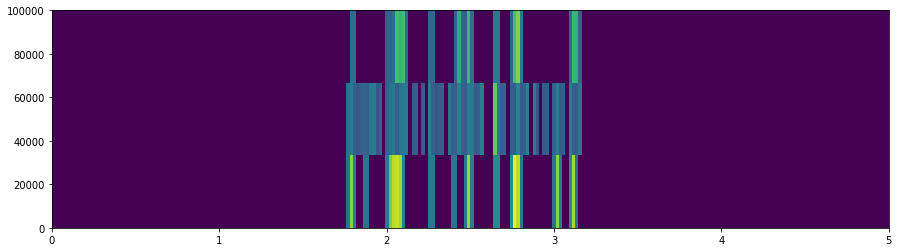

In [15]:
#plt.autoscale(False)
plt.figure(figsize=(15,4))
plt.imshow(enc_im,aspect="auto",extent=(0,5,1e0,1e5),interpolation='nearest')
plt.show()

In [ ]:
%timeit  encode_word("Christopher Schrumm is a god of programming.  Just saying he is that good...",ky,ky2,ky3)

In [16]:

def gen_model(cts):
    #create model
    mdl = Sequential()

    #add model layers
    mdl.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(3,256,1)))
    mdl.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    mdl.add(Conv2D(64, kernel_size=2, activation="relu",data_format='channels_first'))
    mdl.add(BatchNormalization())
    mdl.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    mdl.add(Conv2D(32, kernel_size=2, activation="relu",data_format='channels_first'))
    mdl.add(BatchNormalization())
    mdl.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    mdl.add(Flatten())
    mdl.add(Dense(128, activation='tanh'))
    mdl.add(BatchNormalization())
    mdl.add(Dense(128, activation='relu'))
    mdl.add(BatchNormalization())
    
    mdl.add(Dense(cts, activation="softmax"))
    
    mdl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return mdl

In [17]:
mjrs = run_query_array("select majorName from Major order by majorName")
mjrs = [x[0] for x in mjrs]

In [32]:
def fixt_array(vv):
    rs,cs = vv.shape
    tmp = np.zeros((cs,))
    
    for r in range(rs):
        for c in range(cs):
            tmp[c] = tmp[c] + vv[r][c]
            
    return np.array(tmp)

mj_enc = []

for m in mjrs:
   m_enc = encode_word(m,ky,ky2,ky3)
   fx_a = fixt_array(m_enc)
   mj_enc.append([fx_a])

enc_a = np.concatenate(mj_enc)



In [45]:
#clstrs = int(len(mjrs)/30)+1

cl_rslt =  AffinityPropagation(max_iter=400).fit(enc_a) # KMeans(n_clusters=clstrs).fit(enc_a)


In [46]:
cl_rslt

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=400, preference=None, verbose=False)

In [47]:
rslt = cl_rslt.predict(enc_a)

In [50]:
rslt.max()

131

In [51]:
cl_k = {}
for i,cl in enumerate(rslt):
    if not cl in cl_k:
        cl_k[cl] = []
    
    cl_k[cl].append(mjrs[i])


In [52]:
cl_k

{110: ['Accounting',
  'Area Studies, Other',
  'Auditing',
  'Biopsychology',
  'Chiropractic',
  'Conducting',
  'Corrections',
  'Costume Design',
  'Drawing',
  'Geography',
  'Geropsychology',
  'Health Law',
  'Illustration',
  'Immunology',
  'Insurance',
  'Journalism',
  'Linguistics',
  'Neuroanatomy',
  'Photojournalism',
  'Polysomnography',
  'Publishing',
  'Receptionist',
  'Sculpture',
  'Taxation',
  'Toxicology'],
 0: ['Accounting and Business/Management',
  'Community Organization and Advocacy',
  'Demography and Population Studies',
  'Directing and Theatrical Production',
  'Educational/Instructional Technology',
  'Electrical and Electronics Engineering',
  'Facilities Planning and Management',
  'Geological/Geophysical Engineering',
  'International and Comparative Education',
  'Oceanography, Chemical and Physical',
  'Public Relations/Image Management',
  'Transportation/Mobility Management',
  'Veterinary Pathology and Pathobiology'],
 52: ['Accounting and Com

In [29]:
np.array([2.3,3.4])

array([2.3, 3.4])

In [18]:
mjr_mdl = gen_model(len(mjrs))


In [24]:
x_mjr_train,y_mjr_train = generate_test(100000,mjrs)
x_mjr_val,y_mjr_val = generate_test(500,mjrs)

In [25]:
def train_model(xs,ys,vxs,vys,mdl,cs):
    mdl.fit(xs,ys,batch_size=400,epochs=45,verbose=1,validation_data=(vxs,vys),shuffle=True)
    return 

In [26]:
train_model(x_mjr_train,y_mjr_train,x_mjr_val,y_mjr_val,mjr_mdl,len(mjrs))

Train on 100000 samples, validate on 500 samples
Epoch 1/45
100000/100000 [==============================] - 55s 552us/step - loss: 6.6251 - acc: 0.0033 - val_loss: 6.5803 - val_acc: 0.0060
Epoch 2/45
100000/100000 [==============================] - 48s 477us/step - loss: 6.2107 - acc: 0.0112 - val_loss: 6.3742 - val_acc: 0.0100
Epoch 3/45
100000/100000 [==============================] - 47s 474us/step - loss: 5.5369 - acc: 0.0431 - val_loss: 5.4039 - val_acc: 0.0540
Epoch 4/45
100000/100000 [==============================] - 47s 472us/step - loss: 4.8873 - acc: 0.0982 - val_loss: 4.8030 - val_acc: 0.1280
Epoch 5/45
100000/100000 [==============================] - 47s 475us/step - loss: 4.4202 - acc: 0.1549 - val_loss: 4.6556 - val_acc: 0.1200
Epoch 6/45
100000/100000 [==============================] - 48s 475us/step - loss: 4.0197 - acc: 0.2083 - val_loss: 4.3783 - val_acc: 0.1620
Epoch 7/45
100000/100000 [==============================] - 47s 468us/step - loss: 3.6845 - acc: 0.2582 -

In [ ]:
to_mtch = [
    "Barracuda Fish",
    "Siberian Tiger",
    "Great White Shark",
    "Black Bear",
    "Grizzly Bear",
    "Wart Hog",
    "Black Rhino",
    "White Rhino",
    "Red Tail Hawk",
    "Gosh Hawk"
]

In [20]:
def add_space(sp):
    ib = random.randint(0,len(sp)-1)
    pp = sp[0:ib] + " " + sp[ib:]
    return pp

def change_char(sp):
    ib = random.randint(0,len(sp)-1)
    pp = "" 
    for i, c in enumerate(sp):
        if i == ib:
           pp = pp + alpha[random.randint(0,len(alpha)-1)]
        else:    
           pp = pp + c
   
    return pp

def remove_char(sp):
    ib = random.randint(0,len(sp)-1)
    pp = ""     
    for i, c in enumerate(sp):
        if i == ib:
           continue
        else:    
           pp = pp + c   
    return pp

def add_random_word(sp):
    wrd = random_words[random.randint(0,len(random_words)-1)]
    prts = sp.split(" ")
    ib = random.randint(0,len(prts))
    prts = prts[0:ib] + [wrd.strip()] + prts[ib:]
    return " ".join(prts)

def flip_char(sp):
    idx = random.randint(1,len(sp)-1)
    pp = ""
    p = sp[idx]
    n = sp[idx-1]
    for i,c in enumerate(sp):
        if i == idx - 1:
            pp = pp + p
        elif i == idx:
            pp = pp + n
        else:
            pp = pp + c
    return pp

In [21]:
def test_model_sample(mjr_mdl,to_test):
    idx = random.randint(0,len(to_test)-1)
    print(idx)
    wdr = to_test[idx]
    enc_i = encode_word(wdr,ky,ky2,ky3)
    enc_i = np.reshape(enc_i,(3,256,1))
    #print(enc_i.shape)
    enc_i = np.reshape(enc_i,(1,3,256,1))# np.concatenate(enc_i)
    prd = model.predict(enc_i)
    chs = np.argmax(prd,axis=1)[0]
    print(chs)
    print("chose ",to_test[idx], " predicted ", to_test[chs])
    return

In [122]:
for i in range(400):
    test_model_sample(mjr_mdl,mjrs)

404
5
chose  Early Childhood Education and Teaching  predicted  Accounting Technology/Technician and Bookkeeping
231
3
chose  Chinese Studies  predicted  Accounting and Finance
827
7
chose  Medical Office Assistant/Specialist  predicted  Acting
599
1
chose  Germanic Languages, Literatures, and Linguistics, General  predicted  Accounting and Business/Management
88
5
chose  Anthropology, Other  predicted  Accounting Technology/Technician and Bookkeeping
746
1
chose  Laser and Optical Engineering  predicted  Accounting and Business/Management
372
5
chose  Dental Materials  predicted  Accounting Technology/Technician and Bookkeeping
1161
6
chose  Soil Chemistry and Physics  predicted  Acoustics
982
6
chose  Pharmaceutics and Drug Design  predicted  Acoustics
871
6
chose  Movement Therapy and Movement Education  predicted  Acoustics
331
1
chose  Court Reporting/Court Reporter  predicted  Accounting and Business/Management
333
5
chose  Creative Writing  predicted  Accounting Technology/Techn

In [23]:
fn_chs = [add_space,add_space,change_char,change_char,change_char,change_char,flip_char,flip_char,flip_char,remove_char,remove_char,remove_char,add_random_word,add_random_word]

def generate_test(cnt,to_mtch):
    
    x_s = []
    y_s = []
    
    for i in range(cnt):
        mtx = random.randint(0,len(to_mtch)-1)
        wd = to_mtch[mtx]
        for c in range(5):
            fnc = fn_chs[random.randint(0,len(fn_chs)-1)]
            old = wd
            wd = fnc(wd)
            if len(wd) < 3: # in case we shrunk to much..
                wd = old
        #print(to_mtch[mtx], " ...became... ",wd)
        enc = encode_word(wd,ky,ky2,ky3)
        enc = np.reshape(enc,(3,256,1))
        x_s.append([enc])
        one_e = np.zeros(len(to_mtch),dtype=float)
        one_e[mtx] = 1.0
        y_s.append([one_e])
        
    #print(len(x_s))
    
    return np.concatenate(x_s),np.concatenate(y_s)
    

In [ ]:
x_train,y_train = generate_test(100000,to_mtch)
x_val,y_val = generate_test(500,to_mtch)

In [ ]:
y_train.shape

In [ ]:
model.fit(x_train,y_train,batch_size=200,epochs=25,verbose=1,validation_data=(x_val,y_val))

In [ ]:
idx = 7
wdr =  to_mtch[idx]
wdr = "shit"
print(wdr)
enc_i = encode_word(wdr,ky,ky2,ky3)
enc_i = np.reshape(enc_i,(3,256,1))
print(enc_i.shape)
enc_i = np.reshape(enc_i,(1,3,256,1))# np.concatenate(enc_i)
prd = model.predict(enc_i)
for v in prd[0]:
    print(v)
#print(prd)
print(np.argmax(prd,axis=1))

In [ ]:
random_words[0:0]

In [ ]:
enc_im.shape

In [ ]:
nw_sp = np.reshape(enc_im,(3,256,1))

In [ ]:
nw_sp

In [ ]:
np.zeros(10,dtype=float)